In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [2]:
def histogram_equalization(img_in, flag):
    # segregate color streams
    b, g, r = cv2.split(img_in)
    h_b, bin_b = np.histogram(b, 256, [0, 256])
    h_g, bin_g = np.histogram(g, 256, [0, 256])
    h_r, bin_r = np.histogram(r, 256, [0, 256])

    #---------------------------------
    if flag == True:
        plt.hist(h_b, bin_b, plt.figure().set_figwidth(10))
        plt.title("before histogram equalization of B")
        plt.show()

        plt.hist(h_g, bin_g, plt.figure().set_figwidth(10))
        plt.title("before histogram equalization of G")
        plt.show()

        plt.hist(h_r, bin_r, plt.figure().set_figwidth(10))
        plt.title("before histogram equalization of R")
        plt.show()
    #---------------------------------
    
    # Cumulative distribution function
    cdf_b = np.cumsum(h_b)
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)

    # Normalize the cumulative distribution function
    cdf_norm_b = np.ma.masked_equal(cdf_b, 0)
    cdf_norm_b = ((cdf_norm_b - cdf_norm_b.min()) * 255 / (cdf_norm_b.max() - cdf_norm_b.min()))
    cdf_final_b = np.ma.filled(cdf_norm_b, 0).astype("uint8")

    cdf_norm_g = np.ma.masked_equal(cdf_g, 0)
    cdf_norm_g = ((cdf_norm_g - cdf_norm_g.min()) * 255 / (cdf_norm_g.max() - cdf_norm_g.min()))
    cdf_final_g = np.ma.filled(cdf_norm_g, 0).astype("uint8")
    
    cdf_norm_r = np.ma.masked_equal(cdf_r, 0)
    cdf_norm_r = ((cdf_norm_r - cdf_norm_r.min()) * 255 / (cdf_norm_r.max() - cdf_norm_r.min()))
    cdf_final_r = np.ma.filled(cdf_norm_r, 0).astype("uint8")
    
    #---------------------------------
    if flag == True:
        plt.hist(cdf_final_b, bin_b, plt.figure().set_figwidth(10))
        plt.title("after histogram equalization of B")
        plt.show()

        plt.hist(cdf_final_g, bin_g, plt.figure().set_figwidth(10))
        plt.title("after histogram equalization of G")
        plt.show()

        plt.hist(cdf_final_r, bin_r, plt.figure().set_figwidth(10))
        plt.title("after histogram equalization of R")
        plt.show()
    #---------------------------------
    
    # merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]
    img_out = cv2.merge((img_b, img_g, img_r))

    return img_out

In [3]:
def sharpening(img_in):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(img_in, -1, kernel)
    return sharpened

In [4]:
def edge_detection(channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel

In [5]:
def segmentation_by_edge(img_in, flag):
    # step1: remove noise
    img = cv2.GaussianBlur(img_in, (5, 5), 0)
    
    #---------------------------------
    if flag == True:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('after GaussianBlur')
        plt.show()
    #---------------------------------
    
    # step2: Edge detection
    # finding the max intesity from among the R,G and B edges.
    # 0 --> B, 1 --> G, 2 --> R
    img_edge = np.max(
        np.array(
            [
                edge_detection(img[:, :, 0]),
                edge_detection(img[:, :, 1]),
                edge_detection(img[:, :, 2]),
            ]
        ),
        axis=0,
    )
    
    # step3: Remove the false edge
    mean = np.mean(img_edge)
    img_edge[img_edge <= mean * 1.5] = 0
    
    #---------------------------------
    if flag == True:
        plt.imshow(cv2.cvtColor(img_edge, cv2.COLOR_BGR2RGB))
        plt.title('after edge detection and Remove the false edge')
        plt.show()
    #---------------------------------
    
    # step4 , step5 : Loss of rupture and find contours
    img_edge = np.asarray(img_edge, np.uint8)

    contours, heirarchy = cv2.findContours(img_edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours_level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            contours_level1.append(tupl)

    contours_significant = []
    contors_tooSmall = img_edge.size * 5 / 100
    
    for tupl in contours_level1:
        contour = contours[tupl[0]]
        area = cv2.contourArea(contour)
        if area > contors_tooSmall:
            contours_significant.append([contour, area])
            cv2.drawContours(img, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)

    contours_significant.sort(key=lambda x: x[1])
    significant = [x[0] for x in contours_significant]
    return (img_edge, significant)

In [6]:
def remove_background(img_in, flag):
    img_edge, significant = segmentation_by_edge(img_in, flag)
    mask = img_edge.copy()
    mask[mask > 0] = 0
    
    #---------------------------------
    if flag == True:
        plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        plt.title('mask before select significant')
        plt.show()
    #---------------------------------
    
    cv2.fillPoly(mask, significant, 255)
    
    #---------------------------------
    if flag == True:
        plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        plt.title('mask after select significant')
        plt.show()
    #---------------------------------
    
    mask = np.logical_not(mask)
    img_in[mask] = 255

    return img_in, mask

In [7]:
def feature_extraction(img_in, mask):
    # mean and median and
    feature = []
    feature.append(int(np.mean(img_in[:, :, 0][mask == 0])))
    feature.append(int(np.mean(img_in[:, :, 1][mask == 0])))
    feature.append(int(np.mean(img_in[:, :, 2][mask == 0])))
    feature.append(int(np.median(img_in[:, :, 0][mask == 0])))
    feature.append(int(np.median(img_in[:, :, 1][mask == 0])))
    feature.append(int(np.median(img_in[:, :, 2][mask == 0])))
    return feature

In [8]:
def nemmodar(x_train, x_test):
    x1 = []
    y1 = []
    z1 = []
    for i in range(32):
        x1.append(x_train[i][0])
        y1.append(x_train[i][1])
        z1.append(x_train[i][2])

    x2 = []
    y2 = []
    z2 = []
    for i in range(32):
        x2.append(x_train[i + 32][0])
        y2.append(x_train[i + 32][1])
        z2.append(x_train[i + 32][2])

    xt1 = []
    yt1 = []
    zt1 = []
    for i in range(15):
        xt1.append(x_test[i][0])
        yt1.append(x_test[i][1])
        zt1.append(x_test[i][2])

    xt2 = []
    yt2 = []
    zt2 = []
    for i in range(15):
        xt2.append(x_test[i + 15][0])
        yt2.append(x_test[i + 15][1])
        zt2.append(x_test[i + 15][2])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot3D(x1, y1, z1, "ob")
    ax.plot3D(x2, y2, z2, "or")
    ax.plot3D(xt1, yt1, zt1, "og")
    ax.plot3D(xt2, yt2, zt2, "oc")
    ax.set_xlabel("mean b")
    ax.set_ylabel("mean g")
    ax.set_zlabel("mean r")
    ax.view_init(30, 60)
    plt.show()

In [9]:
def classification(x_train, y_train, x_test, y_true):
    clf = SVC(kernel="rbf")
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(f"accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"y_pred: {y_pred}")
    print(f"y_true: {y_true}")

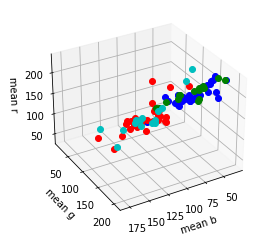

accuracy: 0.9666666666666667
y_pred: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y_true: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
def main():
    y_train = []
    y_test = []
    dirr = "train/"
    active = True
    while active:
        featurs = []
        for i, entry in enumerate(os.scandir(dirr)):
            dir = entry.path
            for j, entry2 in enumerate(os.scandir(dir)):
                image_dir = entry2.path
                img_in = cv2.imread(image_dir)
                num = 0
                if num == 1:
                    img_out = histogram_equalization(img_in, False)
                elif num == 2:
                    img_out = sharpening(img_in)
                elif num == 3:
                    img_out = histogram_equalization(img_in, False)
                    img_out = sharpening(img_out)
                else:
                    img_out = img_in
                img_out, mask = remove_background(img_out, False)
                featurs.append(feature_extraction(img_out, mask))
                if dirr == "train/":
                    if i == 0:
                        y_train.append(1)
                    else:
                        y_train.append(0)
                else:
                    if i == 0:
                        y_test.append(1)
                    else:
                        y_test.append(0)
        if dirr == "train/":
            x_train = featurs.copy()
            dirr = "test/"
        else:
            x_test = featurs.copy()
            active = False

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    nemmodar(x_train, x_test)
    classification(x_train, y_train, x_test, y_test)


if __name__ == "__main__":
    main()


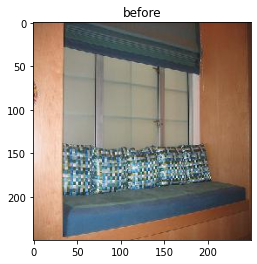

In [16]:
sample_img_in = cv2.imread("other (276).jpg")
plt.imshow(cv2.cvtColor(sample_img_in, cv2.COLOR_BGR2RGB))
plt.title('before')
plt.show()

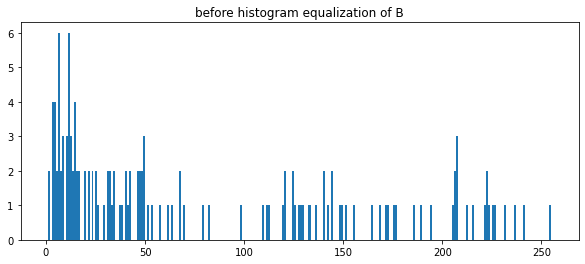

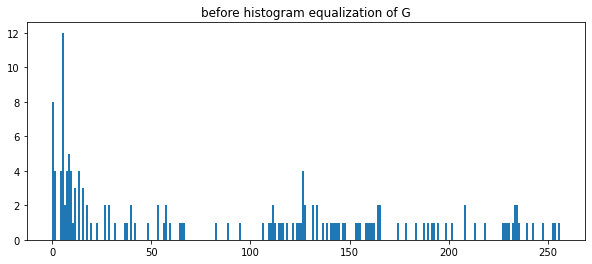

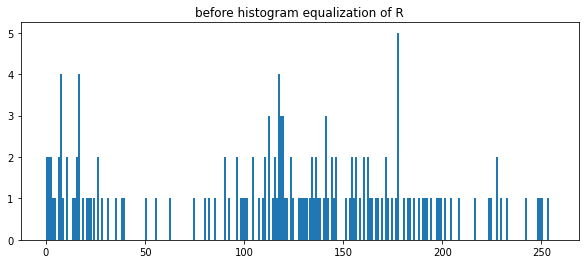

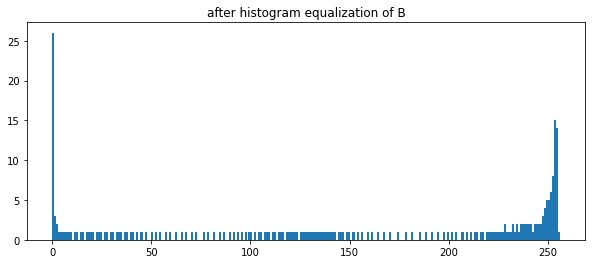

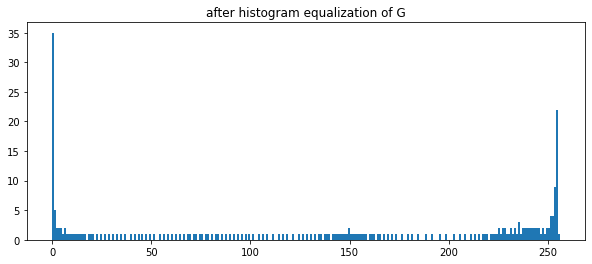

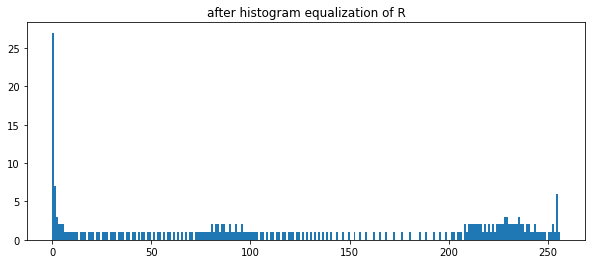

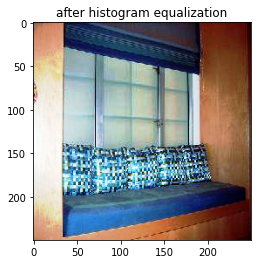

In [18]:
img_out_histogram_equalization = histogram_equalization(sample_img_in, True).copy()
plt.imshow(cv2.cvtColor(img_out_histogram_equalization, cv2.COLOR_BGR2RGB))
plt.title('after histogram equalization')
plt.show()

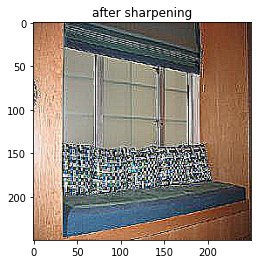

In [9]:
img_out_sharpening = sharpening(sample_img_in).copy()
plt.imshow(cv2.cvtColor(img_out_sharpening, cv2.COLOR_BGR2RGB))
plt.title('after sharpening')
plt.show()

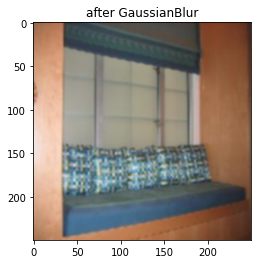

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


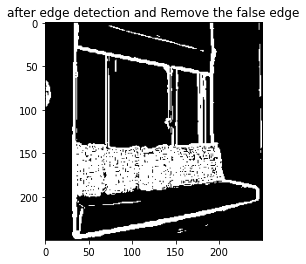

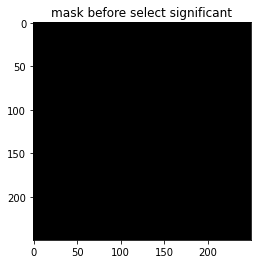

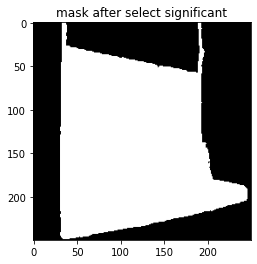

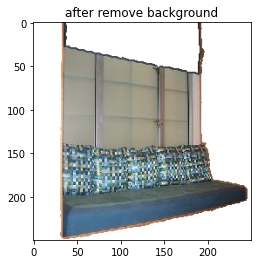

In [15]:
img_out_remove_background, _ = remove_background(cv2.imread("other (276).jpg"), True)
plt.imshow(cv2.cvtColor(img_out_remove_background, cv2.COLOR_BGR2RGB))
plt.title('after remove background')
plt.show()